https://pytorch.org/tutorials/intermediate/tensorboard_profiler_tutorial.html

In [1]:
# For tips on running notebooks in Google Colab, see
# https://pytorch.org/tutorials/beginner/colab
%matplotlib inline


# PyTorch Profiler With TensorBoard
This tutorial demonstrates how to use TensorBoard plugin with PyTorch Profiler
to detect performance bottlenecks of the model.

## Introduction
PyTorch 1.8 includes an updated profiler API capable of
recording the CPU side operations as well as the CUDA kernel launches on the GPU side.
The profiler can visualize this information
in TensorBoard Plugin and provide analysis of the performance bottlenecks.

In this tutorial, we will use a simple Resnet model to demonstrate how to
use TensorBoard plugin to analyze model performance.

## Setup
To install ``torch`` and ``torchvision`` use the following command:

```
pip install torch torchvision
```


## Steps

1. Prepare the data and model
2. Use profiler to record execution events
3. Run the profiler
4. Use TensorBoard to view results and analyze model performance
5. Improve performance with the help of profiler
6. Analyze performance with other advanced features
7. Additional Practices: Profiling PyTorch on AMD GPUs 

### 1. Prepare the data and model

First, import all necessary libraries:




In [1]:
import torch
import torch.nn
import torch.optim
import torch.profiler
import torch.utils.data
import torchvision.datasets
import torchvision.models
import torchvision.transforms as T

/opt/conda/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Then prepare the input data. For this tutorial, we use the CIFAR10 dataset.
Transform it to the desired format and use ``DataLoader`` to load each batch.



In [2]:
transform = T.Compose(
    [
        T.Resize(224),
        T.ToTensor(),
        T.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
    ]
)

train_set = torchvision.datasets.CIFAR10(
    root="./data",
    train=True,
    download=True,
    transform=transform,
)
train_loader = torch.utils.data.DataLoader(train_set, batch_size=32, shuffle=True)

Files already downloaded and verified


Next, create Resnet model, loss function, and optimizer objects.
To run on GPU, move model and loss to GPU device.



In [3]:
device = torch.device("cuda:0")
model = torchvision.models.resnet18(weights="IMAGENET1K_V1").cuda(device)
criterion = torch.nn.CrossEntropyLoss().cuda(device)
optimizer = torch.optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
model.train()

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

Define the training step for each batch of input data.



In [4]:
def train(data):
    inputs, labels = data[0].to(device=device), data[1].to(device=device)
    outputs = model(inputs)
    loss = criterion(outputs, labels)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

### 2. Use profiler to record execution events

The profiler is enabled through the context manager and accepts several parameters,
some of the most useful are:

- ``schedule`` - callable that takes step (int) as a single parameter
  and returns the profiler action to perform at each step.

  In this example with ``wait=1, warmup=1, active=3, repeat=1``,
  profiler will skip the first step/iteration,
  start warming up on the second,
  record the following three iterations,
  after which the trace will become available and on_trace_ready (when set) is called.
  In total, the cycle repeats once. Each cycle is called a "span" in TensorBoard plugin.

  During ``wait`` steps, the profiler is disabled.
  During ``warmup`` steps, the profiler starts tracing but the results are discarded.
  This is for reducing the profiling overhead.
  The overhead at the beginning of profiling is high and easy to bring skew to the profiling result.
  During ``active`` steps, the profiler works and records events.
- ``on_trace_ready`` - callable that is called at the end of each cycle;
  In this example we use ``torch.profiler.tensorboard_trace_handler`` to generate result files for TensorBoard.
  After profiling, result files will be saved into the ``./log/resnet18`` directory.
  Specify this directory as a ``logdir`` parameter to analyze profile in TensorBoard.
- ``record_shapes`` - whether to record shapes of the operator inputs.
- ``profile_memory`` - Track tensor memory allocation/deallocation. Note, for old version of pytorch with version
  before 1.10, if you suffer long profiling time, please disable it or upgrade to new version.
- ``with_stack`` - Record source information (file and line number) for the ops.
  If the TensorBoard is launched in VS Code ([reference](https://code.visualstudio.com/docs/datascience/pytorch-support#_tensorboard-integration)),
  clicking a stack frame will navigate to the specific code line.



In [5]:
with torch.profiler.profile(
    schedule=torch.profiler.schedule(
        wait=1,
        warmup=1,
        active=3,
        repeat=1,
    ),
    on_trace_ready=torch.profiler.tensorboard_trace_handler(
        "spellchecker/kosenko/sandbox/profiling/4_pytorch_tensorboard/log/resnet18",
    ),
    record_shapes=True,
    profile_memory=True,
    with_stack=True,
) as prof:
    for step, batch_data in enumerate(train_loader):
        prof.step()  # Need to call this at each step to notify profiler of steps' boundary.
        if step >= 1 + 1 + 3:
            break
        train(batch_data)

STAGE:2024-03-12 18:01:20 189293:189293 ActivityProfilerController.cpp:312] Completed Stage: Warm Up
[W CPUAllocator.cpp:235] Memory block of unknown size was allocated before the profiling started, profiler results will not include the deallocation event
STAGE:2024-03-12 18:01:20 189293:189293 ActivityProfilerController.cpp:318] Completed Stage: Collection
STAGE:2024-03-12 18:01:20 189293:189293 ActivityProfilerController.cpp:322] Completed Stage: Post Processing


Alternatively, the following non-context manager start/stop is supported as well.



In [6]:
prof = torch.profiler.profile(
    schedule=torch.profiler.schedule(wait=1, warmup=1, active=3, repeat=1),
    on_trace_ready=torch.profiler.tensorboard_trace_handler(
        "spellchecker/kosenko/sandbox/profiling/4_pytorch_tensorboard/log/resnet18/"
    ),
    record_shapes=True,
    with_stack=True,
)
prof.start()
for step, batch_data in enumerate(train_loader):
    prof.step()
    if step >= 1 + 1 + 3:
        break
    train(batch_data)
prof.stop()

STAGE:2024-03-12 18:01:24 189293:189293 ActivityProfilerController.cpp:312] Completed Stage: Warm Up
STAGE:2024-03-12 18:01:24 189293:189293 ActivityProfilerController.cpp:318] Completed Stage: Collection
STAGE:2024-03-12 18:01:24 189293:189293 ActivityProfilerController.cpp:322] Completed Stage: Post Processing


### 3. Run the profiler

Run the above code. The profiling result will be saved under ``./log/resnet18`` directory.



### 4. Use TensorBoard to view results and analyze model performance

<div class="alert alert-info"><h4>Note</h4><p>TensorBoard Plugin support has been deprecated, so some of these functions may not
    work as previously. Please take a look at the replacement, [HTA](https://github.com/pytorch/kineto/tree/main#holistic-trace-analysis).</p></div>

Install PyTorch Profiler TensorBoard Plugin.

```
pip install torch_tb_profiler
```


Launch the TensorBoard.

```
tensorboard --logdir=./log
```


In [9]:
# tensorboard --logdir=spellchecker/kosenko/sandbox/profiling/4_pytorch_tensorboard/log

Open the TensorBoard profile URL in Google Chrome browser or Microsoft Edge browser (**Safari is not supported**).

```
http://localhost:6006/#pytorch_profiler
```


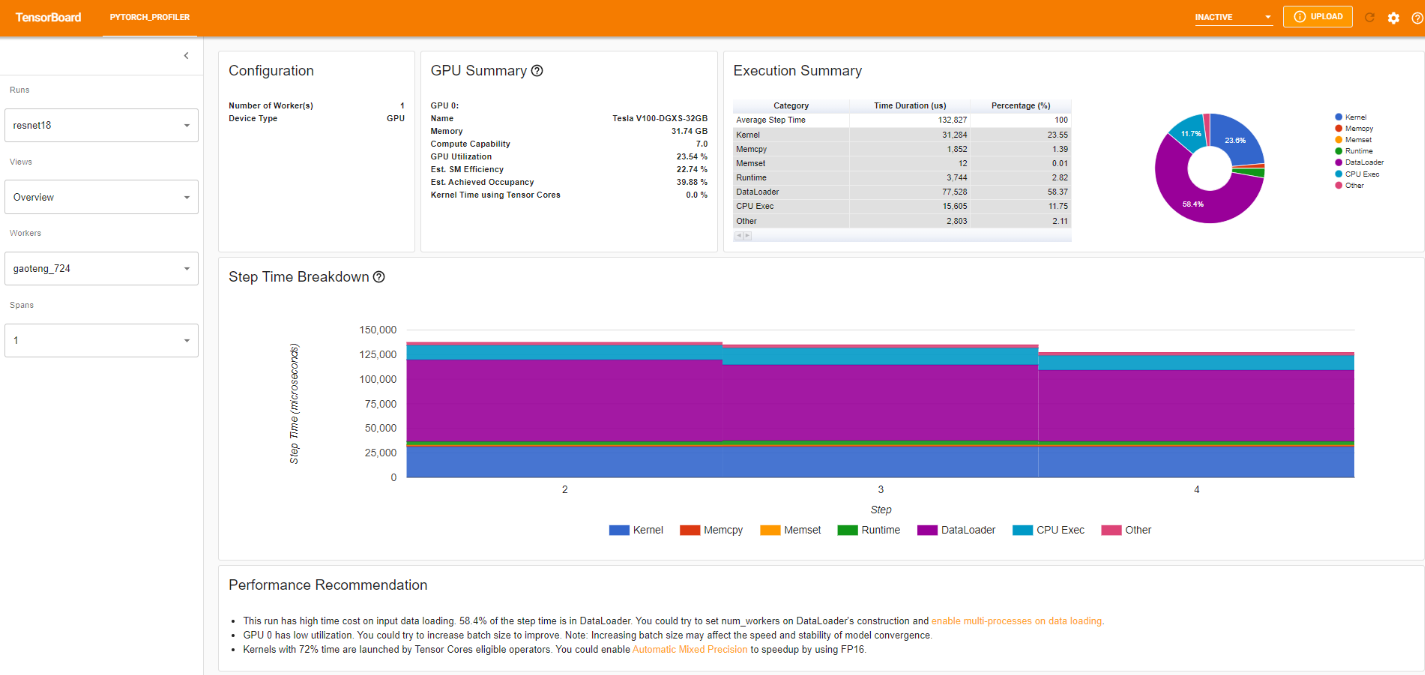

You could see Profiler plugin page as shown below.

- Overview
<img src="file://../../_static/img/profiler_overview1.png" scale="25 %">

The overview shows a high-level summary of model performance.

The "GPU Summary" panel shows the GPU configuration, GPU usage and Tensor Cores usage.
In this example, the GPU Utilization is low.
The details of these metrics are [here](https://github.com/pytorch/kineto/blob/main/tb_plugin/docs/gpu_utilization.md).

The "Step Time Breakdown" shows distribution of time spent in each step over different categories of execution.
In this example, you can see the ``DataLoader`` overhead is significant.

The bottom "Performance Recommendation" uses the profiling data
to automatically highlight likely bottlenecks,
and gives you actionable optimization suggestions.

You can change the view page in left "Views" dropdown list.

<img src="file://../../_static/img/profiler_views_list.png"
   :alt:>


- Operator view
The operator view displays the performance of every PyTorch operator
that is executed either on the host or device.

<img src="file://../../_static/img/profiler_operator_view.png" scale="25 %">
The "Self" duration does not include its child operators’ time.
The "Total" duration includes its child operators’ time.

- View call stack
Click the ``View Callstack`` of an operator, the operators with same name but different call stacks will be shown.
Then click a ``View Callstack`` in this sub-table, the call stack frames will be shown.

<img src="file://../../_static/img/profiler_callstack.png" scale="25 %">

If the TensorBoard is launched inside VS Code
([Launch Guide](https://devblogs.microsoft.com/python/python-in-visual-studio-code-february-2021-release/#tensorboard-integration)),
clicking a call stack frame will navigate to the specific code line.

<img src="file://../../_static/img/profiler_vscode.png" scale="25 %">


- Kernel view
The GPU kernel view shows all kernels’ time spent on GPU.

<img src="file://../../_static/img/profiler_kernel_view.png" scale="25 %">
Tensor Cores Used:
Whether this kernel uses Tensor Cores.

Mean Blocks per SM:
Blocks per SM = Blocks of this kernel / SM number of this GPU.
If this number is less than 1, it indicates the GPU multiprocessors are not fully utilized.
"Mean Blocks per SM" is weighted average of all runs of this kernel name, using each run’s duration as weight.

Mean Est. Achieved Occupancy:
Est. Achieved Occupancy is defined in this column’s tooltip.
For most cases such as memory bandwidth bounded kernels, the higher the better.
"Mean Est. Achieved Occupancy" is weighted average of all runs of this kernel name,
using each run’s duration as weight.

- Trace view
The trace view shows timeline of profiled operators and GPU kernels.
You can select it to see details as below.

<img src="file://../../_static/img/profiler_trace_view1.png" scale="25 %">

You can move the graph and zoom in/out with the help of right side toolbar.
And keyboard can also be used to zoom and move around inside the timeline.
The ‘w’ and ‘s’ keys zoom in centered around the mouse,
and the ‘a’ and ‘d’ keys move the timeline left and right.
You can hit these keys multiple times until you see a readable representation.

If a backward operator's "Incoming Flow" field is with value "forward correspond to backward",
you can click the text to get its launching forward operator.

<img src="file://../../_static/img/profiler_trace_view_fwd_bwd.png" scale="25 %">

In this example, we can see the event prefixed with ``enumerate(DataLoader)`` costs a lot of time.
And during most of this period, the GPU is idle.
Because this function is loading data and transforming data on host side,
during which the GPU resource is wasted.



### 5. Improve performance with the help of profiler

At the bottom of "Overview" page, the suggestion in "Performance Recommendation" hints the bottleneck is ``DataLoader``.
The PyTorch ``DataLoader`` uses single process by default.
User could enable multi-process data loading by setting the parameter ``num_workers``.
[Here](https://pytorch.org/docs/stable/data.html#single-and-multi-process-data-loading) is more details.

In this example, we follow the "Performance Recommendation" and set ``num_workers`` as below,
pass a different name such as ``./log/resnet18_4workers`` to ``tensorboard_trace_handler``, and run it again.

```
train_loader = torch.utils.data.DataLoader(train_set, batch_size=32, shuffle=True, num_workers=4)
```


Then let’s choose the recently profiled run in left "Runs" dropdown list.

<img src="file://../../_static/img/profiler_overview2.png" scale="25 %">

From the above view, we can find the step time is reduced to about 76ms comparing with previous run's 132ms,
and the time reduction of ``DataLoader`` mainly contributes.

<img src="file://../../_static/img/profiler_trace_view2.png" scale="25 %">

From the above view, we can see that the runtime of ``enumerate(DataLoader)`` is reduced,
and the GPU utilization is increased.



### 6. Analyze performance with other advanced features

- Memory view
To profile memory, ``profile_memory`` must be set to ``True`` in arguments of ``torch.profiler.profile``.

You can try it by using existing example on Azure

```
pip install azure-storage-blob
tensorboard --logdir=https://torchtbprofiler.blob.core.windows.net/torchtbprofiler/demo/memory_demo_1_10
```
The profiler records all memory allocation/release events and allocator's internal state during profiling.
The memory view consists of three components as shown in the following.

<img src="file://../../_static/img/profiler_memory_view.png" scale="25 %">

The components are memory curve graph, memory events table and memory statistics table, from top to bottom, respectively.

The memory type could be selected in "Device" selection box.
For example, "GPU0" means the following table only shows each operator's memory usage on GPU 0, not including CPU or other GPUs.

The memory curve shows the trends of memory consumption. The "Allocated" curve shows the total memory that is actually
in use, e.g., tensors. In PyTorch, caching mechanism is employed in CUDA allocator and some other allocators. The
"Reserved" curve shows the total memory that is reserved by the allocator. You can left click and drag on the graph
to select events in the desired range:

<img src="file://../../_static/img/profiler_memory_curve_selecting.png" scale="25 %">

After selection, the three components will be updated for the restricted time range, so that you can gain more
information about it. By repeating this process, you can zoom into a very fine-grained detail. Right click on the graph
will reset the graph to the initial state.

<img src="file://../../_static/img/profiler_memory_curve_single.png" scale="25 %">

In the memory events table, the allocation and release events are paired into one entry. The "operator" column shows
the immediate ATen operator that is causing the allocation. Notice that in PyTorch, ATen operators commonly use
``aten::empty`` to allocate memory. For example, ``aten::ones`` is implemented as ``aten::empty`` followed by an
``aten::fill_``. Solely display the operator name as ``aten::empty`` is of little help. It will be shown as
``aten::ones (aten::empty)`` in this special case. The "Allocation Time", "Release Time" and "Duration"
columns' data might be missing if the event occurs outside of the time range. 

In the memory statistics table, the "Size Increase" column sums up all allocation size and minus all the memory
release size, that is, the net increase of memory usage after this operator. The "Self Size Increase" column is
similar to "Size Increase", but it does not count children operators' allocation. With regards to ATen operators'
implementation detail, some operators might call other operators, so memory allocations can happen at any level of the
call stack. That says, "Self Size Increase" only count the memory usage increase at current level of call stack.
Finally, the "Allocation Size" column sums up all allocation without considering the memory release.

- Distributed view
The plugin now supports distributed view on profiling DDP with NCCL/GLOO as backend.

You can try it by using existing example on Azure:

```
pip install azure-storage-blob
tensorboard --logdir=https://torchtbprofiler.blob.core.windows.net/torchtbprofiler/demo/distributed_bert
```
<img src="file://../../_static/img/profiler_distributed_view.png" scale="25 %">

The "Computation/Communication Overview" shows computation/communication ratio and their overlapping degree.
From this view, User can figure out load balance issue among workers.
For example, if the computation + overlapping time of one worker is much larger than others,
there may be a problem of load balance or this worker may be a straggler.

The "Synchronizing/Communication Overview" shows the efficiency of communication.
"Data Transfer Time" is the time for actual data exchanging.
"Synchronizing Time" is the time for waiting and synchronizing with other workers.

If one worker’s "Synchronizing Time" is much shorter than that of other workers’,
this worker may be a straggler which may have more computation workload than other workers’.

The "Communication Operations Stats" summarizes the detailed statistics of all communication ops in each worker.



### 7. Additional Practices: Profiling PyTorch on AMD GPUs


The AMD ROCm Platform is an open-source software stack designed for GPU computation, consisting of drivers, development tools, and APIs. 
We can run the above mentioned steps on AMD GPUs. In this section, we will use Docker to install the ROCm base development image
before installing PyTorch.



For the purpose of example, let's create a directory called ``profiler_tutorial``, and save the code in **Step 1** as ``test_cifar10.py`` in this directory. 

```
mkdir ~/profiler_tutorial
cd profiler_tutorial
vi test_cifar10.py
```


At the time of this writing, the Stable(``2.1.1``) Linux version of PyTorch on ROCm Platform is [ROCm 5.6](https://pytorch.org/get-started/locally/). 


- Obtain a base Docker image with the correct user-space ROCm version installed from [Docker Hub](https://hub.docker.com/repository/docker/rocm/dev-ubuntu-20.04).

It is ``rocm/dev-ubuntu-20.04:5.6``.

- Start the ROCm base Docker container:


```
docker run -it --network=host --device=/dev/kfd --device=/dev/dri --group-add=video --ipc=host --cap-add=SYS_PTRACE --security-opt seccomp=unconfined --shm-size 8G -v ~/profiler_tutorial:/profiler_tutorial rocm/dev-ubuntu-20.04:5.6
```
- Inside the container, install any dependencies needed for installing the wheels package.

```
sudo apt update
sudo apt install libjpeg-dev python3-dev -y
pip3 install wheel setuptools
sudo apt install python-is-python3
```
- Install the wheels:

```
pip3 install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/rocm5.6
```
- Install the ``torch_tb_profiler``, and then, run the Python file ``test_cifar10.py``:

```
pip install torch_tb_profiler
cd /profiler_tutorial
python test_cifar10.py
```
Now, we have all the data needed to view in TensorBoard:

```
tensorboard --logdir=./log
```
Choose different views as described in **Step 4**. For example, below is the **Operator** View:

<img src="file://../../_static/img/profiler_rocm_tensorboard_operartor_view.png" scale="25 %">



At the time this section is written, **Trace** view does not work and it displays nothing. You can work around by typing ``chrome://tracing`` in your Chrome Browser.


- Copy the ``trace.json`` file under ``~/profiler_tutorial/log/resnet18`` directory to the Windows.  
You may need to copy the file by using ``scp`` if the file is located in a remote location. 

- Click **Load** button to load the trace JSON file from the ``chrome://tracing`` page in the browser. 

<img src="file://../../_static/img/profiler_rocm_chrome_trace_view.png" scale="25 %">



As mentioned previously, you can move the graph and zoom in and out.
You can also use keyboard to zoom and move around inside the timeline.
The ``w`` and ``s`` keys zoom in centered around the mouse,
and the ``a`` and ``d`` keys move the timeline left and right.
You can hit these keys multiple times until you see a readable representation.



## Learn More

Take a look at the following documents to continue your learning,
and feel free to open an issue [here](https://github.com/pytorch/kineto/issues).

-  [PyTorch TensorBoard Profiler Github](https://github.com/pytorch/kineto/tree/master/tb_plugin)
-  [torch.profiler API](https://pytorch.org/docs/master/profiler.html)
-  [HTA](https://github.com/pytorch/kineto/tree/main#holistic-trace-analysis)

